In [15]:
import pandas as pd
import random
import numpy as np
from datetime import datetime, timedelta
from typing import List, Tuple, Dict
import copy
from openpyxl import load_workbook
import os

In [16]:
Rooms = pd.read_excel("../../data/Raw Data/Data.xlsx" , sheet_name="Rooms")
Courses = pd.read_excel("../../data/Raw Data/Data.xlsx" , sheet_name="Courses" )
Doctors = pd.read_excel("../../data/Raw Data/Data.xlsx" , sheet_name="Doctors" )
Divisions = pd.read_excel("../../data/Raw Data/Data.xlsx" , sheet_name="Division" )

# Try to load Times sheet, create empty DataFrame if it doesn't exist
try:
    Times = pd.read_excel("../../data/Raw Data/Data.xlsx" , sheet_name="Times" )
except:
    # If Times sheet doesn't exist, create empty DataFrame with expected columns
    Times = pd.DataFrame(columns=['Day', 'Slot_ID', 'Start_Time', 'End_Time'])

In [17]:
Rooms.head(10)

,Room_ID,Room,Capacity,Type
0,R1,Room 1,30,Lab
1,R2,Room 2,30,Lab
2,R3,Room 3,30,Lab
3,R4,Room 4,30,Lab
4,R5,Room 5,30,Lab
5,T8,Terrace 8,250,Lecture
6,T4,terrace4,100,Lecture
7,H16,Hall 16,100,Lecture


In [18]:
Courses.head(10)

,Course_ID,Course_Name,Department,Major,Days,Hours_per_day,Instructor_ID,Year,Type,Duration
0,C01,Mathematics (0),IT,IT,2,1,I12,1,Lecture,1 Hour
1,C02,Mathematics (1),IT,IT,2,1,I12,1,Lecture,1 Hour
2,C03,Electronics,IT,IT,2,1,I13,1,Lecture,1 Hour
3,C04,Discrete Mathematics,IT,IT,2,1,I16,1,Lecture,1 Hour
4,C05,Introduction to Computers,IT,IT,2,1,I18,1,Lecture,1 Hour
5,C06,Mathematics-3,IT,IT,2,1,I16,2,Lecture,1 Hour
6,C07,Computer Networks Technology,IT,IT,2,1,I14,2,Lecture,1 Hour
7,C08,Introduction to Software Engineering,IT,IT,2,1,I15,2,Lecture,1 Hour
8,C09,Object Oriented Programming,IT,IT,2,1,I03,2,Lecture,1 Hour
9,C10,Probability and Statistics-2,IT,IT,2,1,I05,2,Lecture,1 Hour


In [19]:
Doctors.head(10)

,Instructor_ID,Instructor_Name,Department,Day,Start_Time,End_Time
0,I01,Dr. Shimaa Mosaad,IT,Saturday,08:00:00,21:00:00
1,I01,Dr. Shimaa Mosaad,IT,Tuesday,08:00:00,21:00:00
2,I02,Dr. Kamal Hamza,IT,Sunday,14:00:00,15:00:00
3,I02,Dr. Kamal Hamza,IT,Wednesday,14:00:00,03:00:00
4,I03,Dr. Yasser,IT,Monday,14:00:00,03:00:00
5,I03,Dr. Yasser,IT,Thursday,14:00:00,03:00:00
6,I04,Dr. Adel Fathy Khalifa,IT,Saturday,12:00:00,13:00:00
7,I04,Dr. Adel Fathy Khalifa,IT,Tuesday,12:00:00,13:00:00
8,I05,Dr. Abdelbaset,IT,Monday,15:00:00,16:00:00
9,I05,Dr. Abdelbaset,IT,Thursday,03:00:00,04:00:00


In [20]:
Divisions.head(20)

,Num_ID,Department,Major,Year,StudentNum
0,D01,IT,IT,1,219
1,D03,IT,IT,2,235
2,D05,IT,IT,3,264
3,D07,IT,IT,4,299
4,D09,BA,BA,1,125
5,D11,BA,BA,2,127
6,D13,BA,BA,3,65
7,D15,BA,AC,3,117
8,D17,BA,BA,4,54
9,D19,BA,AC,4,77


In [21]:
# Helper function to parse time strings (handles AM/PM format)
def parse_time(time_str):
    """Convert time string (HH:MM:SS or HH:MM AM/PM) to minutes since midnight"""
    try:
        if isinstance(time_str, str):
            time_str = time_str.strip().upper()
            
            # Check for AM/PM
            is_pm = 'PM' in time_str
            is_am = 'AM' in time_str
            
            # Remove AM/PM from string
            time_str = time_str.replace('AM', '').replace('PM', '').strip()
            
            parts = time_str.split(':')
            hours = int(parts[0])
            minutes = int(parts[1]) if len(parts) > 1 else 0
            
            # Handle 12:00 AM (midnight) and 12:00 PM (noon)
            if hours == 12:
                if is_am:
                    hours = 0  # 12:00 AM = midnight (0 hours)
                # 12:00 PM stays as 12
            elif is_pm and hours != 12:
                hours += 12  # Convert PM to 24-hour format (except 12 PM)
            
            return hours * 60 + minutes
        return 0
    except:
        return 0

# Helper function to convert minutes back to time string (12-hour AM/PM format)
def minutes_to_time_str(minutes):
    """Convert minutes since midnight to 12-hour format with AM/PM (e.g., '1:00 PM')"""
    if minutes == 0:
        return "12:00 AM"
    hours = minutes // 60
    mins = minutes % 60
    # Handle 24-hour format - if hours >= 24, wrap around
    hours = hours % 24
    
    # Convert to 12-hour format
    if hours == 0:
        hour_12 = 12
        period = "AM"
    elif hours < 12:
        hour_12 = hours
        period = "AM"
    elif hours == 12:
        hour_12 = 12
        period = "PM"
    else:
        hour_12 = hours - 12
        period = "PM"
    
    return f"{hour_12}:{mins:02d} {period}"

# Helper function to check if time ranges overlap
def time_ranges_overlap(start1, end1, start2, end2):
    """Check if two time ranges overlap"""
    return not (end1 <= start2 or end2 <= start1)

# Helper function to check if time is within range
def is_time_in_range(time_minutes, start_minutes, end_minutes):
    """Check if time is within the given range"""
    if end_minutes < start_minutes:  # Handle next day
        return time_minutes >= start_minutes or time_minutes <= end_minutes
    return start_minutes <= time_minutes <= end_minutes

print("Helper functions defined")


Helper functions defined


In [22]:
# Prepare data structures for easier access
# Create dictionaries for quick lookup
room_dict = {row['Room_ID']: {'capacity': row['Capacity'], 'type': row['Type']} 
             for _, row in Rooms.iterrows()}

course_dict = {row['Course_ID']: {
    'instructor': row['Instructor_ID'],
    'days': row['Days'],
    'hours_per_day': row['Hours_per_day'],
    'type': row['Type'],
    'year': row['Year'],
    'major': row['Major'],
    'department': row['Department']
} for _, row in Courses.iterrows()}

# Doctor availability: {instructor_id: {day: [(start, end), ...]}}
# Uses doctors' times directly (now supports AM/PM format)
doctor_availability = {}
for _, row in Doctors.iterrows():
    inst_id = row['Instructor_ID']
    day = row['Day']
    
    # Parse times directly - parse_time now handles AM/PM format
    start = parse_time(str(row['Start_Time']))
    end = parse_time(str(row['End_Time']))
    
    if inst_id not in doctor_availability:
        doctor_availability[inst_id] = {}
    if day not in doctor_availability[inst_id]:
        doctor_availability[inst_id][day] = []
    doctor_availability[inst_id][day].append((start, end))

# Note: Using doctors' times only - Times sheet not needed

# Divisions: {num_id: {'students': count, 'year': year, 'major': major}}
division_dict = {row['Num_ID']: {
    'students': row['StudentNum'],
    'year': row['Year'],
    'major': row['Major'],
    'department': row['Department']
} for _, row in Divisions.iterrows()}

# Get all valid rooms by type
lecture_rooms = [r for r in room_dict.keys() if room_dict[r]['type'] == 'Lecture']
lab_rooms = [r for r in room_dict.keys() if room_dict[r]['type'] == 'Lab']

print(f"Data prepared: {len(course_dict)} courses, {len(room_dict)} rooms, {len(division_dict)} divisions")
print(f"Lecture rooms: {len(lecture_rooms)}, Lab rooms: {len(lab_rooms)}")


Data prepared: 53 courses, 8 rooms, 10 divisions
Lecture rooms: 3, Lab rooms: 5


In [23]:
class SchedulingGA:
    def __init__(self, courses_df, rooms_df, doctors_df, times_df, divisions_df, 
                 pop_size=100, generations=200, mutation_rate=0.1, crossover_rate=0.8):
        self.pop_size = pop_size
        self.generations = generations
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        
        # Store dataframes
        self.courses_df = courses_df
        self.rooms_df = rooms_df
        self.doctors_df = doctors_df
        self.times_df = times_df
        self.divisions_df = divisions_df
        
        # Prepare data
        self.prepare_data()
        
    def prepare_data(self):
        """Prepare data structures for GA"""
        # Get all courses that need scheduling
        self.courses = self.courses_df['Course_ID'].tolist()
        
        # Get all divisions matching courses
        self.divisions = []
        for _, course_row in self.courses_df.iterrows():
            course_id = course_row['Course_ID']
            year = course_row['Year']
            major = course_row['Major']
            dept = course_row['Department']
            
            # Find matching divisions
            matching_divs = self.divisions_df[
                (self.divisions_df['Year'] == year) &
                (self.divisions_df['Major'] == major) &
                (self.divisions_df['Department'] == dept)
            ]['Num_ID'].tolist()
            
            for div_id in matching_divs:
                self.divisions.append((course_id, div_id))
        
        # Get all days from Times, or from Doctors if Times is empty
        if len(self.times_df) > 0 and 'Day' in self.times_df.columns:
            self.days = self.times_df['Day'].unique().tolist()
        elif len(self.doctors_df) > 0 and 'Day' in self.doctors_df.columns:
            self.days = self.doctors_df['Day'].unique().tolist()
        else:
            # Fallback to common days
            self.days = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Saturday']
        
        # Get all rooms
        self.all_rooms = self.rooms_df['Room_ID'].tolist()
        self.lecture_rooms = self.rooms_df[self.rooms_df['Type'] == 'Lecture']['Room_ID'].tolist()
        self.lab_rooms = self.rooms_df[self.rooms_df['Type'] == 'Lab']['Room_ID'].tolist()
        
    def create_individual(self):
        """Create a random individual (schedule)"""
        schedule = []
        
        for course_id, div_id in self.divisions:
            course_info = self.courses_df[self.courses_df['Course_ID'] == course_id].iloc[0]
            div_info = self.divisions_df[self.divisions_df['Num_ID'] == div_id].iloc[0]
            
            instructor_id = course_info['Instructor_ID']
            course_type = course_info['Type']
            days_needed = int(course_info['Days'])
            hours_per_day = int(course_info['Hours_per_day'])
            duration_minutes = hours_per_day * 60  # Convert hours to minutes
            
            # Select appropriate rooms - be more flexible
            if course_type == 'Lecture':
                # First try rooms with sufficient capacity
                available_rooms = [r for r in self.lecture_rooms 
                                  if self.rooms_df[self.rooms_df['Room_ID'] == r]['Capacity'].iloc[0] >= div_info['StudentNum']]
                # If none, try largest available room (allow slight overflow)
                if not available_rooms:
                    available_rooms = self.lecture_rooms
                    # Sort by capacity descending and take the largest
                    available_rooms = sorted(available_rooms, 
                                            key=lambda r: self.rooms_df[self.rooms_df['Room_ID'] == r]['Capacity'].iloc[0], 
                                            reverse=True)
            else:
                # First try rooms with sufficient capacity
                available_rooms = [r for r in self.lab_rooms 
                                  if self.rooms_df[self.rooms_df['Room_ID'] == r]['Capacity'].iloc[0] >= div_info['StudentNum']]
                # If none, try largest available room (allow slight overflow)
                if not available_rooms:
                    available_rooms = self.lab_rooms
                    # Sort by capacity descending and take the largest
                    available_rooms = sorted(available_rooms, 
                                            key=lambda r: self.rooms_df[self.rooms_df['Room_ID'] == r]['Capacity'].iloc[0], 
                                            reverse=True)
            
            if not available_rooms:
                continue
            
            # Try to schedule for required days
            available_days = [d for d in self.days 
                             if instructor_id in doctor_availability and d in doctor_availability[instructor_id]]
            
            # If no available days for instructor, try all days (will be penalized in fitness)
            if not available_days:
                available_days = self.days.copy()
            
            # Ensure we schedule for the exact number of days required
            if len(available_days) < days_needed:
                # If not enough available days, use all available days and fill with other days
                scheduled_days = available_days.copy()
                # Add additional days from all days to meet the requirement
                remaining_days_needed = days_needed - len(scheduled_days)
                other_days = [d for d in self.days if d not in scheduled_days]
                if remaining_days_needed > 0 and len(other_days) > 0:
                    scheduled_days.extend(random.sample(other_days, min(remaining_days_needed, len(other_days))))
            else:
                # Select exactly the required number of days
                scheduled_days = random.sample(available_days, days_needed)
            
            # Track how many days we've successfully scheduled for this course
            days_scheduled_count = 0
            
            for day in scheduled_days:
                # Stop if we've already scheduled the required number of days
                if days_scheduled_count >= days_needed:
                    break
                    
                scheduled_this_day = False
                # Get doctor's available time slots for this day
                if instructor_id in doctor_availability and day in doctor_availability[instructor_id]:
                    # Find a time slot that can accommodate the required duration
                    suitable_slots = []
                    for doc_start, doc_end in doctor_availability[instructor_id][day]:
                        # Calculate available duration in this slot
                        available_duration = doc_end - doc_start
                        # Handle wrap-around (next day)
                        if available_duration < 0:
                            available_duration = (24 * 60) - doc_start + doc_end
                        
                        # Check if this slot can fit the required duration
                        if available_duration >= duration_minutes:
                            suitable_slots.append((doc_start, doc_end))
                    
                    if suitable_slots:
                        # Choose a random suitable slot
                        doc_start, doc_end = random.choice(suitable_slots)
                        # Calculate actual end time based on duration
                        lecture_end = doc_start + duration_minutes
                        # Handle wrap-around to next day
                        lecture_end_normalized = lecture_end % (24 * 60) if lecture_end >= 24 * 60 else lecture_end
                        
                        # Ensure the lecture fits within doctor's availability
                        fits_in_availability = False
                        if doc_start <= doc_end:  # Normal case (same day)
                            fits_in_availability = (lecture_end_normalized <= doc_end)
                        else:  # Wrap-around case (next day)
                            # For wrap-around: if lecture doesn't wrap, it's within [doc_start, 1440)
                            # If lecture wraps, lecture_end_normalized should be <= doc_end
                            if lecture_end < 24 * 60:
                                # Lecture doesn't wrap, so it's within availability
                                fits_in_availability = True
                            else:
                                # Lecture wraps, check if normalized end is within [0, doc_end]
                                fits_in_availability = (lecture_end_normalized <= doc_end)
                        
                        if fits_in_availability:
                            # Use normalized end time
                            lecture_end = lecture_end_normalized
                            room = random.choice(available_rooms)
                            schedule.append({
                                'Day': day,
                                'Course_ID': course_id,
                                'Instructor_ID': instructor_id,
                                'Group_ID': div_id,
                                'Room_ID': room,
                                'Time_Slot': f"{day}_{doc_start}_{lecture_end}",
                                'Start_Time': doc_start,
                                'End_Time': lecture_end,
                                'Duration': duration_minutes  # Store duration for validation
                            })
                            scheduled_this_day = True
                            days_scheduled_count += 1
                            # Only schedule one slot per day - continue to next day
                            continue
                
                # If no suitable slot found, schedule with default time to ensure we meet the day requirement
                # (will be penalized in fitness but at least the course is scheduled for required days)
                if not scheduled_this_day:
                    # Use a default time slot (8 AM) - will be penalized if not in doctor availability
                    default_start = 8 * 60  # 8:00 AM
                    default_end = default_start + duration_minutes
                    room = random.choice(available_rooms)
                    schedule.append({
                        'Day': day,
                        'Course_ID': course_id,
                        'Instructor_ID': instructor_id,
                        'Group_ID': div_id,
                        'Room_ID': room,
                        'Time_Slot': f"{day}_{default_start}_{default_end}",
                        'Start_Time': default_start,
                        'End_Time': default_end,
                        'Duration': duration_minutes
                    })
                    days_scheduled_count += 1
                    # Continue to next day to schedule all required days
        
        return schedule
    
    def fitness(self, individual):
        """Calculate fitness of an individual (lower is better)"""
        violations = 0
        penalty = 0
        
        # Track conflicts
        room_time_conflicts = {}  # {(room, day, time): count}
        instructor_time_conflicts = {}  # {(instructor, day, time): count}
        division_time_conflicts = {}  # {(division, day, time): count}
        
        for assignment in individual:
            room = assignment['Room_ID']
            day = assignment['Day']
            instructor = assignment['Instructor_ID']
            division = assignment['Group_ID']
            time_start = assignment['Start_Time']
            time_end = assignment['End_Time']
            course_id = assignment['Course_ID']
            
            # Get course information
            course_info = self.courses_df[self.courses_df['Course_ID'] == course_id].iloc[0]
            required_hours = int(course_info['Hours_per_day'])
            required_duration_minutes = required_hours * 60
            
            # Check lecture duration matches Hours_per_day
            actual_duration = time_end - time_start
            # Handle wrap-around (next day)
            if actual_duration < 0:
                actual_duration = (24 * 60) - time_start + time_end
            
            # Check if duration matches required hours (allow small tolerance for rounding)
            if abs(actual_duration - required_duration_minutes) > 5:  # 5 minutes tolerance
                violations += 10
                penalty += 100
            
            # Check room capacity
            room_capacity = self.rooms_df[self.rooms_df['Room_ID'] == room]['Capacity'].iloc[0]
            div_students = self.divisions_df[self.divisions_df['Num_ID'] == division]['StudentNum'].iloc[0]
            if room_capacity < div_students:
                violations += 10
                penalty += 100
            
            # Check room type matches course type
            room_type = self.rooms_df[self.rooms_df['Room_ID'] == room]['Type'].iloc[0]
            course_type = course_info['Type']
            if room_type != course_type:
                violations += 10
                penalty += 100
            
            # Check instructor availability - ensure full lecture duration fits
            if instructor in doctor_availability and day in doctor_availability[instructor]:
                available = False
                for doc_start, doc_end in doctor_availability[instructor][day]:
                    # Check if the entire lecture (start to end) fits within doctor's availability
                    if doc_start <= doc_end:  # Normal case (same day)
                        if time_start >= doc_start and time_end <= doc_end:
                            available = True
                            break
                    else:  # Wrap-around case (next day)
                        # For wrap-around: time_start should be >= doc_start OR time_end <= doc_end
                        # But we also need to ensure the entire lecture fits
                        if (time_start >= doc_start or time_end <= doc_end):
                            # Additional check: if time_start < doc_start, then time_end must be <= doc_end
                            # If time_start >= doc_start, then time_end can wrap around but must be <= doc_end
                            if time_start >= doc_start:
                                # Started after wrap point, end should be <= doc_end
                                if time_end <= doc_end:
                                    available = True
                                    break
                            else:
                                # Started before wrap point, end must be <= doc_end
                                if time_end <= doc_end:
                                    available = True
                                    break
                
                if not available:
                    violations += 5
                    penalty += 50
            
            # Track time conflicts (check for overlapping time slots)
            # Room conflicts - check if room is double-booked
            room_conflict = False
            for other_assignment in individual:
                if other_assignment == assignment:
                    continue
                if (other_assignment['Room_ID'] == room and 
                    other_assignment['Day'] == day and
                    time_ranges_overlap(time_start, time_end, 
                                       other_assignment['Start_Time'], 
                                       other_assignment['End_Time'])):
                    room_conflict = True
                    violations += 5
                    penalty += 50
                    break
            
            # Instructor conflicts - check if instructor is double-booked
            inst_conflict = False
            for other_assignment in individual:
                if other_assignment == assignment:
                    continue
                if (other_assignment['Instructor_ID'] == instructor and 
                    other_assignment['Day'] == day and
                    time_ranges_overlap(time_start, time_end, 
                                       other_assignment['Start_Time'], 
                                       other_assignment['End_Time'])):
                    inst_conflict = True
                    violations += 5
                    penalty += 50
                    break
            
            # Division conflicts (same group cannot have two classes at same time)
            div_conflict = False
            for other_assignment in individual:
                if other_assignment == assignment:
                    continue
                if (other_assignment['Group_ID'] == division and 
                    other_assignment['Day'] == day and
                    time_ranges_overlap(time_start, time_end, 
                                       other_assignment['Start_Time'], 
                                       other_assignment['End_Time'])):
                    div_conflict = True
                    violations += 5
                    penalty += 50
                    break
        
        # Check if all course-division pairs are scheduled
        scheduled_pairs = set()
        course_days_count = {}
        for assignment in individual:
            course_id = assignment['Course_ID']
            div_id = assignment['Group_ID']
            scheduled_pairs.add((course_id, div_id))
            if course_id not in course_days_count:
                course_days_count[course_id] = set()
            course_days_count[course_id].add(assignment['Day'])
        
        # Heavy penalty for missing course-division pairs
        for course_id, div_id in self.divisions:
            if (course_id, div_id) not in scheduled_pairs:
                violations += 50  # Very high penalty for completely missing pairs
                penalty += 500
        
        # Check if all courses are scheduled with required days - STRICT PENALTY
        for course_id in self.courses:
            required_days = int(self.courses_df[self.courses_df['Course_ID'] == course_id]['Days'].iloc[0])
            if course_id not in course_days_count or len(course_days_count[course_id]) < required_days:
                missing_days = required_days - (len(course_days_count[course_id]) if course_id in course_days_count else 0)
                violations += 50 * missing_days  # Very high penalty per missing day
                penalty += 500 * missing_days  # Very high penalty per missing day
        
        return violations + penalty / 1000
    
    def crossover(self, parent1, parent2):
        """Single-point crossover"""
        if random.random() > self.crossover_rate:
            return parent1.copy(), parent2.copy()
        
        # Create child schedules
        child1 = []
        child2 = []
        
        # Get all unique course-division pairs
        p1_assignments = {(a['Course_ID'], a['Group_ID']): a for a in parent1}
        p2_assignments = {(a['Course_ID'], a['Group_ID']): a for a in parent2}
        
        all_pairs = set(list(p1_assignments.keys()) + list(p2_assignments.keys()))
        split_point = len(all_pairs) // 2
        
        pairs_list = list(all_pairs)
        random.shuffle(pairs_list)
        
        for i, pair in enumerate(pairs_list):
            if i < split_point:
                if pair in p1_assignments:
                    child1.append(p1_assignments[pair].copy())
                if pair in p2_assignments:
                    child2.append(p2_assignments[pair].copy())
            else:
                if pair in p2_assignments:
                    child1.append(p2_assignments[pair].copy())
                if pair in p1_assignments:
                    child2.append(p1_assignments[pair].copy())
        
        return child1, child2
    
    def mutate(self, individual):
        """Mutate an individual"""
        if random.random() > self.mutation_rate:
            return individual
        
        mutated = individual.copy()
        
        if len(mutated) == 0:
            return mutated
        
        # Random mutation operations
        mutation_type = random.choice(['change_room', 'change_time', 'remove', 'add'])
        
        if mutation_type == 'change_room' and len(mutated) > 0:
            idx = random.randint(0, len(mutated) - 1)
            assignment = mutated[idx]
            course_id = assignment['Course_ID']
            div_id = assignment['Group_ID']
            
            course_info = self.courses_df[self.courses_df['Course_ID'] == course_id].iloc[0]
            div_info = self.divisions_df[self.divisions_df['Num_ID'] == div_id].iloc[0]
            
            if course_info['Type'] == 'Lecture':
                available_rooms = [r for r in self.lecture_rooms 
                                if self.rooms_df[self.rooms_df['Room_ID'] == r]['Capacity'].iloc[0] >= div_info['StudentNum']]
            else:
                available_rooms = [r for r in self.lab_rooms 
                                if self.rooms_df[self.rooms_df['Room_ID'] == r]['Capacity'].iloc[0] >= div_info['StudentNum']]
            
            if available_rooms:
                assignment['Room_ID'] = random.choice(available_rooms)
        
        elif mutation_type == 'change_time' and len(mutated) > 0:
            idx = random.randint(0, len(mutated) - 1)
            assignment = mutated[idx]
            day = assignment['Day']
            instructor = assignment['Instructor_ID']
            course_id = assignment['Course_ID']
            
            # Get course duration
            course_info = self.courses_df[self.courses_df['Course_ID'] == course_id].iloc[0]
            hours_per_day = int(course_info['Hours_per_day'])
            duration_minutes = hours_per_day * 60
            
            # Change to a different doctor availability slot that can fit the duration
            if instructor in doctor_availability and day in doctor_availability[instructor]:
                suitable_slots = []
                for doc_start, doc_end in doctor_availability[instructor][day]:
                    available_duration = doc_end - doc_start
                    if available_duration < 0:
                        available_duration = (24 * 60) - doc_start + doc_end
                    
                    if available_duration >= duration_minutes:
                        suitable_slots.append((doc_start, doc_end))
                
                if suitable_slots:
                    doc_start, doc_end = random.choice(suitable_slots)
                    lecture_end = doc_start + duration_minutes
                    lecture_end_normalized = lecture_end % (24 * 60) if lecture_end >= 24 * 60 else lecture_end
                    
                    # Ensure the lecture fits within doctor's availability
                    fits_in_availability = False
                    if doc_start <= doc_end:  # Normal case (same day)
                        fits_in_availability = (lecture_end_normalized <= doc_end)
                    else:  # Wrap-around case (next day)
                        if lecture_end < 24 * 60:
                            fits_in_availability = True
                        else:
                            fits_in_availability = (lecture_end_normalized <= doc_end)
                    
                    if fits_in_availability:
                        assignment['Start_Time'] = doc_start
                        assignment['End_Time'] = lecture_end_normalized
                        assignment['Time_Slot'] = f"{day}_{doc_start}_{lecture_end_normalized}"
                        if 'Duration' not in assignment:
                            assignment['Duration'] = duration_minutes
        
        elif mutation_type == 'remove' and len(mutated) > 0:
            mutated.pop(random.randint(0, len(mutated) - 1))
        
        elif mutation_type == 'add':
            # Try to add a new assignment
            course_id, div_id = random.choice(self.divisions)
            course_info = self.courses_df[self.courses_df['Course_ID'] == course_id].iloc[0]
            div_info = self.divisions_df[self.divisions_df['Num_ID'] == div_id].iloc[0]
            instructor_id = course_info['Instructor_ID']
            course_type = course_info['Type']
            hours_per_day = int(course_info['Hours_per_day'])
            duration_minutes = hours_per_day * 60
            
            if course_type == 'Lecture':
                available_rooms = [r for r in self.lecture_rooms 
                                if self.rooms_df[self.rooms_df['Room_ID'] == r]['Capacity'].iloc[0] >= div_info['StudentNum']]
            else:
                available_rooms = [r for r in self.lab_rooms 
                                if self.rooms_df[self.rooms_df['Room_ID'] == r]['Capacity'].iloc[0] >= div_info['StudentNum']]
            
            if available_rooms and instructor_id in doctor_availability:
                available_days = [d for d in self.days 
                                if d in doctor_availability[instructor_id]]
                if available_days:
                    day = random.choice(available_days)
                    # Find suitable slots that can accommodate the duration
                    suitable_slots = []
                    for doc_start, doc_end in doctor_availability[instructor_id][day]:
                        available_duration = doc_end - doc_start
                        if available_duration < 0:
                            available_duration = (24 * 60) - doc_start + doc_end
                        
                        if available_duration >= duration_minutes:
                            suitable_slots.append((doc_start, doc_end))
                    
                    if suitable_slots:
                        doc_start, doc_end = random.choice(suitable_slots)
                        lecture_end = doc_start + duration_minutes
                        lecture_end_normalized = lecture_end % (24 * 60) if lecture_end >= 24 * 60 else lecture_end
                        
                        # Ensure the lecture fits within doctor's availability
                        fits_in_availability = False
                        if doc_start <= doc_end:  # Normal case (same day)
                            fits_in_availability = (lecture_end_normalized <= doc_end)
                        else:  # Wrap-around case (next day)
                            if lecture_end < 24 * 60:
                                fits_in_availability = True
                            else:
                                fits_in_availability = (lecture_end_normalized <= doc_end)
                        
                        if fits_in_availability:
                            room = random.choice(available_rooms)
                            mutated.append({
                                'Day': day,
                                'Course_ID': course_id,
                                'Instructor_ID': instructor_id,
                                'Group_ID': div_id,
                                'Room_ID': room,
                                'Time_Slot': f"{day}_{doc_start}_{lecture_end_normalized}",
                                'Start_Time': doc_start,
                                'End_Time': lecture_end_normalized,
                                'Duration': duration_minutes
                            })
        
        return mutated
    
    def select_parents(self, population, fitness_scores):
        """Tournament selection"""
        tournament_size = 3
        parent1 = min(random.sample(range(len(population)), tournament_size), 
                     key=lambda i: fitness_scores[i])
        parent2 = min(random.sample(range(len(population)), tournament_size), 
                     key=lambda i: fitness_scores[i])
        return population[parent1], population[parent2]
    
    def run(self):
        """Run the genetic algorithm"""
        print("Initializing population...")
        population = [self.create_individual() for _ in range(self.pop_size)]
        
        best_fitness_history = []
        
        for generation in range(self.generations):
            # Calculate fitness
            fitness_scores = [self.fitness(ind) for ind in population]
            best_idx = min(range(len(population)), key=lambda i: fitness_scores[i])
            best_fitness = fitness_scores[best_idx]
            best_fitness_history.append(best_fitness)
            
            if generation % 10 == 0:
                print(f"Generation {generation}: Best fitness = {best_fitness:.2f}, "
                      f"Avg fitness = {np.mean(fitness_scores):.2f}, "
                      f"Best schedule has {len(population[best_idx])} assignments")
            
            # Create new population
            new_population = []
            
            # Elitism: keep best individual
            new_population.append(copy.deepcopy(population[best_idx]))
            
            # Generate offspring
            while len(new_population) < self.pop_size:
                parent1, parent2 = self.select_parents(population, fitness_scores)
                child1, child2 = self.crossover(parent1, parent2)
                child1 = self.mutate(child1)
                child2 = self.mutate(child2)
                new_population.extend([child1, child2])
            
            # Trim to population size
            population = new_population[:self.pop_size]
        
        # Return best individual
        final_fitness = [self.fitness(ind) for ind in population]
        best_idx = min(range(len(population)), key=lambda i: final_fitness[i])
        
        print(f"\nFinal best fitness: {final_fitness[best_idx]:.2f}")
        print(f"Best schedule has {len(population[best_idx])} assignments")
        
        return population[best_idx], best_fitness_history

print("Genetic Algorithm class defined")


Genetic Algorithm class defined


In [24]:
# Initialize and run the GA
ga = SchedulingGA(
    courses_df=Courses,
    rooms_df=Rooms,
    doctors_df=Doctors,
    times_df=Times,
    divisions_df=Divisions,
    pop_size=50,  # Reduced for faster execution
    generations=100,  # Reduced for faster execution
    mutation_rate=0.15,
    crossover_rate=0.8
)

best_schedule, fitness_history = ga.run()


Initializing population...
Generation 0: Best fitness = 893.85, Avg fitness = 949.60, Best schedule has 106 assignments
Generation 10: Best fitness = 893.85, Avg fitness = 2821.64, Best schedule has 106 assignments
Generation 20: Best fitness = 893.85, Avg fitness = 2785.07, Best schedule has 106 assignments
Generation 30: Best fitness = 893.85, Avg fitness = 2806.28, Best schedule has 106 assignments
Generation 40: Best fitness = 893.85, Avg fitness = 2711.34, Best schedule has 106 assignments
Generation 50: Best fitness = 893.85, Avg fitness = 2729.32, Best schedule has 106 assignments
Generation 60: Best fitness = 893.85, Avg fitness = 2763.86, Best schedule has 106 assignments
Generation 70: Best fitness = 893.85, Avg fitness = 2622.06, Best schedule has 106 assignments
Generation 80: Best fitness = 893.85, Avg fitness = 2721.75, Best schedule has 106 assignments
Generation 90: Best fitness = 893.85, Avg fitness = 2727.00, Best schedule has 106 assignments

Final best fitness: 893.

In [25]:
# Convert best schedule to DataFrame format with full details
schedule_data = []
for assignment in best_schedule:
    course_id = assignment['Course_ID']
    instructor_id = assignment['Instructor_ID']
    group_id = assignment['Group_ID']
    room_id = assignment['Room_ID']
    day = assignment['Day']
    
    # Get course details
    course_info = Courses[Courses['Course_ID'] == course_id].iloc[0]
    
    # Get instructor details
    instructor_info = Doctors[Doctors['Instructor_ID'] == instructor_id].iloc[0]
    
    # Get division details
    division_info = Divisions[Divisions['Num_ID'] == group_id].iloc[0]
    
    # Get room details
    room_info = Rooms[Rooms['Room_ID'] == room_id].iloc[0]
    
    # Get time from assignment (stored as minutes)
    start_time_min = assignment.get('Start_Time', 0)
    end_time_min = assignment.get('End_Time', 0)
    
    # Get times from doctor availability (using doctors' times only)
    if (start_time_min == 0 or end_time_min == 0) and instructor_id in doctor_availability:
        if day in doctor_availability[instructor_id]:
            # Get the time slot that was used (first one available)
            time_slot = doctor_availability[instructor_id][day][0]
            start_time_min = time_slot[0]
            end_time_min = time_slot[1]
    
    # Convert time from minutes to 12-hour AM/PM format
    if start_time_min > 0 and end_time_min > 0:
        start_time_str = minutes_to_time_str(start_time_min)
        end_time_str = minutes_to_time_str(end_time_min)
    else:
        # Fallback: use time from doctor availability or default
        if instructor_id in doctor_availability and day in doctor_availability[instructor_id]:
            time_slot = doctor_availability[instructor_id][day][0]
            start_time_str = minutes_to_time_str(time_slot[0])
            end_time_str = minutes_to_time_str(time_slot[1])
        else:
            # Default times in 12-hour format
            start_time_str = minutes_to_time_str(8 * 60)  # 8:00 AM
            end_time_str = minutes_to_time_str(17 * 60)    # 5:00 PM
    
    # Get Students - check if column exists, otherwise use StudentNum
    if 'Students' in division_info:
        students_value = division_info['Students']
    elif 'StudentNum' in division_info:
        students_value = division_info['StudentNum']
    else:
        students_value = division_info.get('Groups', 'N/A')
    
    schedule_data.append({
        'Day': day,
        'Course_Name': course_info['Course_Name'],
        'Instructor_Name': instructor_info['Instructor_Name'],
        'Students': students_value,
        'Room': room_info['Room'],
        'Start_Time': start_time_str,
        'End_Time': end_time_str,
        'Department': course_info['Department'],
        'Major': course_info['Major']
    })

# Create Schedule DataFrame in the format shown in the image
Schedule = pd.DataFrame(schedule_data)

# Verify that courses with multiple days are scheduled correctly
print("\n" + "=" * 80)
print("VERIFICATION: Courses with multiple days per week")
print("=" * 80)
course_day_counts = {}
for assignment in best_schedule:
    course_id = assignment['Course_ID']
    if course_id not in course_day_counts:
        course_day_counts[course_id] = []
    course_day_counts[course_id].append(assignment['Day'])

for course_id in sorted(course_day_counts.keys()):
    course_info = Courses[Courses['Course_ID'] == course_id].iloc[0]
    required_days = int(course_info['Days'])
    scheduled_days = len(set(course_day_counts[course_id]))
    if required_days > 1:
        status = "✓" if scheduled_days >= required_days else "✗"
        print(f"{status} {course_info['Course_Name']}: Required {required_days} days, Scheduled {scheduled_days} days")
        if scheduled_days < required_days:
            print(f"   WARNING: Missing {required_days - scheduled_days} day(s)!")

# Display the schedule
print(f"\nGenerated schedule with {len(Schedule)} assignments:")
print(Schedule.head(20))
print(f"\nTotal assignments: {len(Schedule)}")
print(f"\nSchedule columns: {list(Schedule.columns)}")



VERIFICATION: Courses with multiple days per week
✓ Mathematics (0): Required 2 days, Scheduled 2 days
✓ Mathematics (1): Required 2 days, Scheduled 2 days
✓ Electronics : Required 2 days, Scheduled 2 days
✓ Discrete Mathematics : Required 2 days, Scheduled 2 days
✓ Introduction to Computers: Required 2 days, Scheduled 2 days
✓ Mathematics-3 : Required 2 days, Scheduled 2 days
✓ Computer Networks Technology: Required 2 days, Scheduled 2 days
✓ Introduction to Software Engineering: Required 2 days, Scheduled 2 days
✓ Object Oriented Programming : Required 2 days, Scheduled 2 days
✓ Probability and Statistics-2: Required 2 days, Scheduled 2 days
✓ Introduction to Database systems : Required 2 days, Scheduled 2 days
✓ Network Routing and Switching-Lab: Required 2 days, Scheduled 2 days
✓ Operating systems: Required 2 days, Scheduled 2 days
✓ Digital Signal Processor: Required 2 days, Scheduled 2 days
✓ Artificial Intelligence: Required 2 days, Scheduled 2 days
✓ Algorithms analysis and d

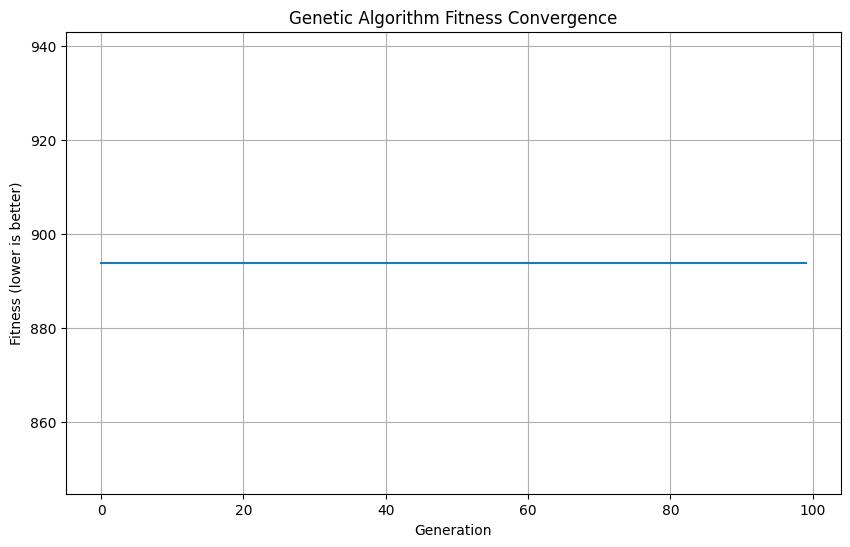

In [26]:
# Visualize fitness convergence
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(fitness_history)
plt.xlabel('Generation')
plt.ylabel('Fitness (lower is better)')
plt.title('Genetic Algorithm Fitness Convergence')
plt.grid(True)
plt.show()


In [27]:


# Ensure Processed Data directory exists
processed_data_dir = "../../data/Processed Data"
os.makedirs(processed_data_dir, exist_ok=True)

# Save to Processed Data folder
output_path = "../../data/Processed Data/Schedule_Output.xlsx"
Schedule.to_excel(output_path, sheet_name='Schedule', index=False)
print(f"Schedule saved to {output_path} successfully!")


Schedule saved to ../../data/Processed Data/Schedule_Output.xlsx successfully!


In [28]:
# Diagnostic: Check which courses are missing and why
print("=" * 80)
print("DIAGNOSTIC: Missing Courses Analysis")
print("=" * 80)

# Get all scheduled course-division pairs
scheduled_course_divs = set()
for assignment in best_schedule:
    scheduled_course_divs.add((assignment['Course_ID'], assignment['Group_ID']))

# Get all expected course-division pairs from GA
all_expected_pairs = set(ga.divisions)

# Find missing pairs
missing_pairs = all_expected_pairs - scheduled_course_divs

print(f"\nTotal courses in data: {len(Courses)}")
print(f"Total course-division pairs expected: {len(all_expected_pairs)}")
print(f"Total course-division pairs scheduled: {len(scheduled_course_divs)}")
print(f"Missing course-division pairs: {len(missing_pairs)}")

# Analyze missing courses
missing_courses = set()
for course_id, div_id in missing_pairs:
    missing_courses.add(course_id)

print(f"\nUnique courses missing: {len(missing_courses)}")
print(f"\nMissing Course IDs: {sorted(missing_courses)}")

# For each missing course, check why it might not be scheduled
print("\n" + "=" * 80)
print("Detailed Analysis of Missing Courses:")
print("=" * 80)

for course_id in sorted(missing_courses):
    course_info = Courses[Courses['Course_ID'] == course_id].iloc[0]
    print(f"\nCourse ID: {course_id}")
    print(f"  Course Name: {course_info['Course_Name']}")
    print(f"  Instructor: {course_info['Instructor_ID']}")
    print(f"  Type: {course_info['Type']}")
    print(f"  Days Required: {course_info['Days']}")
    print(f"  Hours per Day: {course_info['Hours_per_day']}")
    print(f"  Year: {course_info['Year']}, Major: {course_info['Major']}, Dept: {course_info['Department']}")
    
    # Check matching divisions
    matching_divs = Divisions[
        (Divisions['Year'] == course_info['Year']) &
        (Divisions['Major'] == course_info['Major']) &
        (Divisions['Department'] == course_info['Department'])
    ]
    print(f"  Matching Divisions: {len(matching_divs)}")
    if len(matching_divs) == 0:
        print(f"   PROBLEM: No matching divisions found!")
    
    # Check instructor availability
    instructor_id = course_info['Instructor_ID']
    if instructor_id in doctor_availability:
        available_days = list(doctor_availability[instructor_id].keys())
        print(f"  Instructor Available Days: {available_days}")
        if len(available_days) < course_info['Days']:
            print(f"   PROBLEM: Instructor only available {len(available_days)} days, but {course_info['Days']} days required!")
    else:
        print(f"   PROBLEM: No instructor availability data found!")
    
    # Check room availability for each division
    course_type = course_info['Type']
    if course_type == 'Lecture':
        available_rooms = lecture_rooms
    else:
        available_rooms = lab_rooms
    
    for _, div_row in matching_divs.iterrows():
        div_id = div_row['Num_ID']
        student_count = div_row['StudentNum']
        suitable_rooms = [r for r in available_rooms 
                          if room_dict[r]['capacity'] >= student_count]
        print(f"    Division {div_id} ({student_count} students): {len(suitable_rooms)} suitable rooms")
        if len(suitable_rooms) == 0:
            print(f"       PROBLEM: No rooms with capacity >= {student_count}!")

print("\n" + "=" * 80)


DIAGNOSTIC: Missing Courses Analysis

Total courses in data: 53
Total course-division pairs expected: 53
Total course-division pairs scheduled: 53
Missing course-division pairs: 0

Unique courses missing: 0

Missing Course IDs: []

Detailed Analysis of Missing Courses:

